<a href="https://colab.research.google.com/github/aiyazsarwar/100-pandas-puzzles/blob/master/HAR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

#https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels

# Utility function to print the confusion matrix
def plot_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    confusionMatx = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    print(confusionMatx)

    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

    return

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive/Colab Notebooks/UCI_HAR_Dataset"

activity_labels.txt  _DS_Store		features.txt  test
csv_files	     features_info.txt	README.txt    train


### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/gdrive/My Drive/Colab Notebooks/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/gdrive/My Drive/Colab Notebooks/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30




7352/7352 [==============================] - 31s 4ms/step - loss: 1.3174 - acc: 0.4421 - val_loss: 1.1341 - val_acc: 0.4835
Epoch 2/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.9761 - acc: 0.5778 - val_loss: 0.9061 - val_acc: 0.6023
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7827 - acc: 0.6459 - val_loss: 0.7952 - val_acc: 0.6098
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7027 - acc: 0.6544 - val_loss: 0.8491 - val_acc: 0.5796
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.6593 - acc: 0.6666 - val_loss: 0.7274 - val_acc: 0.6152
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.6333 - acc: 0.6657 - val_loss: 1.1423 - val_acc: 0.4886
Epoch 7/30
7352/7352 [====================

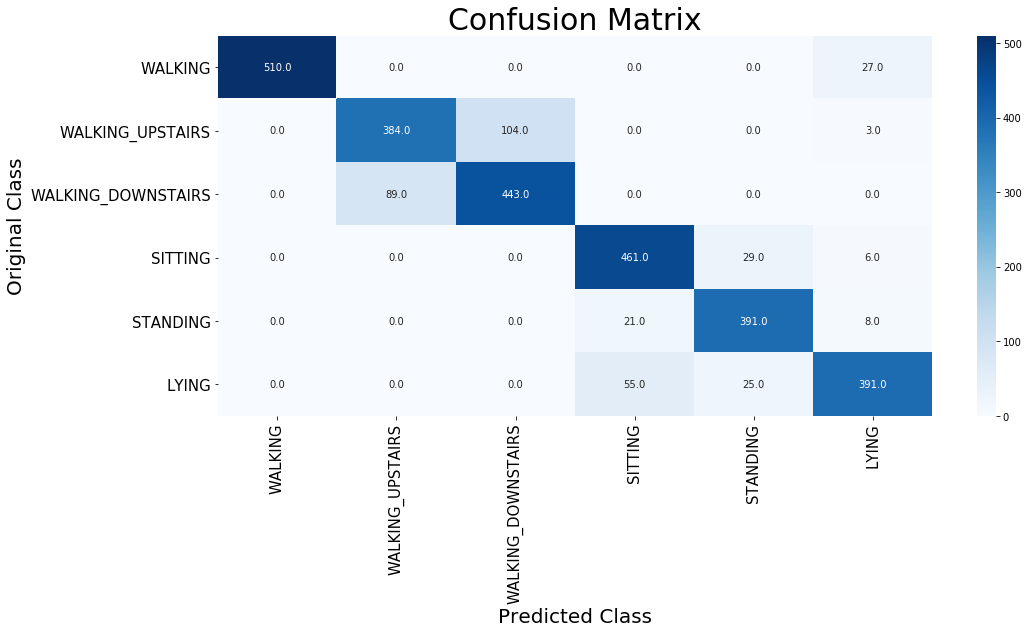

In [0]:
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])
confusionMatx = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    
plt.figure(figsize=(16,7))
sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Class', fontsize = 20)
plt.ylabel('Original Class', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 90)
plt.show()

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  0      384  ...                   0                 3
STANDING                 0       89  ...                   0                 0
WALKING                  0        0  ...                  29                 6
WALKING_DOWNSTAIRS       0        0  ...                 391                 8
WALKING_UPSTAIRS         0        0  ...                  25               391

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 336us/step


In [0]:
score

[0.6656655673765173, 0.8754665761791652]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

In [0]:
#dropOutValue=0.5
#optimizer = 'rmsprop',
# Initializing parameters
# epochs = 30
# batch_size = 16
# n_hidden = 32
# input_dim = len(X_train[0][0])
# n_classes = _count_classes(Y_train)

def model_one_layer(n_hidden,input_dim,dropOutValue,n_classes,optimizer,X_train,Y_train,batch_size,epochs,X_test,Y_test):

  # Initiliazing the sequential model
  model = Sequential()
  # Configuring the parameters
  model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
  # Adding a dropout layer
  model.add(Dropout(dropOutValue))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(n_classes, activation='sigmoid'))
  print('\n*******Model Summary*******\n ' ,model.summary())

  # Compiling the model
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  # Training the model
  histo = model.fit(X_train,
            Y_train,
            batch_size=batch_size,
            validation_data=(X_test, Y_test),
            epochs=epochs)

  # Confusion Matrix
  print('\n**********************Confusion Matrix********************\n')
  confusion_matrix(Y_test, model.predict(X_test))
  confusionMatx = confusion_matrix(Y_test, model.predict(X_test))
  labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
      
  plt.figure(figsize=(16,7))
  sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
  plt.title("Confusion Matrix", fontsize = 30)
  plt.xlabel('Predicted Class', fontsize = 20)
  plt.ylabel('Original Class', fontsize = 20)
  plt.tick_params(labelsize = 15)
  plt.xticks(rotation = 90)
  plt.show()
  #score

  print('\n*******************Train Score********************\n ')
  print('\nTrain loss : ',histo.history['loss'])
  print('\nTrain Accuracy : ',histo.history['accuracy'])

  print('\n*******************Test Score***************************\n ',model.evaluate(X_test, Y_test))

  return

Changing the optimizer to adam and keeping all values same as above and observing the accuracy

In [0]:
model_one_layer(32,len(X_train[0][0]),0.5,_count_classes(Y_train),'adam',X_train,Y_train,16,30,X_test,Y_test)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
*******Model Summary*******
  None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.4138 - acc: 0.3878 - val_loss: 1.3508 - val_acc: 0.3556
Epoch 2/30
7352/7352 [==============================] - 31s 4ms/step - loss: 1.2605 - acc: 0.4468 - val_loss: 1.1868 - val_acc: 0.4791
Epoch 3/30
7352/7352 [=======

Accuracy has decreased a slight with adam optimizer.

Evaluating the model with 32 hidden layers and a large drop out rate of 0.60

In [0]:
model_one_layer(32,len(X_train[0][0]),0.6,_count_classes(Y_train),'rmsprop',X_train,Y_train,16,30,X_test,Y_test)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
*******Model Summary*******
  None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.4121 - acc: 0.3716 - val_loss: 1.2772 - val_acc: 0.5124
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.1388 - acc: 0.5139 - val_loss: 1.1053 - val_acc: 0.4927
Epoch 3/30
7352/7352 [=======

In [0]:
model_one_layer(32,len(X_train[0][0]),0.55,_count_classes(Y_train),'rmsprop',X_train,Y_train,16,30,X_test,Y_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
*******Model Summary*******
  None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.3728 - acc: 0.4236 - val_loss: 1.1032 - val_acc: 0.5480
Epoch 2/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.9700 - acc: 0.5736 - val_loss: 0.8195 - val_acc: 0.6383
Epoch 3/30
7352/7352 [=======

In [0]:
model_one_layer(64,len(X_train[0][0]),0.55,_count_classes(Y_train),'rmsprop',X_train,Y_train,16,30,X_test,Y_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
*******Model Summary*******
  None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 39s 5ms/step - loss: 1.2609 - acc: 0.4397 - val_loss: 1.0661 - val_acc: 0.5643
Epoch 2/30
7352/7352 [==============================] - 36s 5ms/step - loss: 1.0203 - acc: 0.5462 - val_loss: 1.4065 - val_acc: 0.3960
Epoch 3/30
7352/7352 [=====

In [0]:
model_one_layer(64,len(X_train[0][0]),0.60,_count_classes(Y_train),'rmsprop',X_train,Y_train,16,30,X_test,Y_test)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
*******Model Summary*******
  None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 39s 5ms/step - loss: 1.2493 - acc: 0.4612 - val_loss: 1.0575 - val_acc: 0.5334
Epoch 2/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.9454 - acc: 0.5793 - val_loss: 0.8372 - val_acc: 0.5772
Epoch 3/30
7352/7352 [=====

Defining a 2 layer LSTM and larger drop out rate

In [0]:
def model_two_layer(n_hidden,input_dim,dropOutValue,n_classes,optimizer,X_train,Y_train,batch_size,epochs,X_test,Y_test):

  # Initiliazing the sequential model
  model = Sequential()
  # Configuring the parameters
  model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
  # Adding a dropout layer
  model.add(Dropout(dropOutValue))
  #Adding 2nd layer LSTM
  model.add(LSTM(n_hidden))
   # Adding a dropout layer
  model.add(Dropout(dropOutValue))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(n_classes, activation='sigmoid'))
  print('\n*******Model Summary*******\n ' ,model.summary())

  # Compiling the model
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  # Training the model
  histo = model.fit(X_train,
            Y_train,
            batch_size=batch_size,
            validation_data=(X_test, Y_test),
            epochs=epochs)

    # Confusion Matrix
  print('\n**********************Confusion Matrix********************\n')
  confusion_matrix(Y_test, model.predict(X_test))
  confusionMatx = confusion_matrix(Y_test, model.predict(X_test))
  labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
      
  plt.figure(figsize=(16,7))
  sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
  plt.title("Confusion Matrix", fontsize = 30)
  plt.xlabel('Predicted Class', fontsize = 20)
  plt.ylabel('Original Class', fontsize = 20)
  plt.tick_params(labelsize = 15)
  plt.xticks(rotation = 90)
  plt.show()
  #score

  print('\n*******************Train Score********************\n ')
  print('\nTrain loss : ',histo.history['loss'])
  print('\nTrain Accuracy : ',histo.history['accuracy'])
  print('\n*******************Test Score***************************\n ',model.evaluate(X_test, Y_test))
  return

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________

*******Model Summary*******
  None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==========

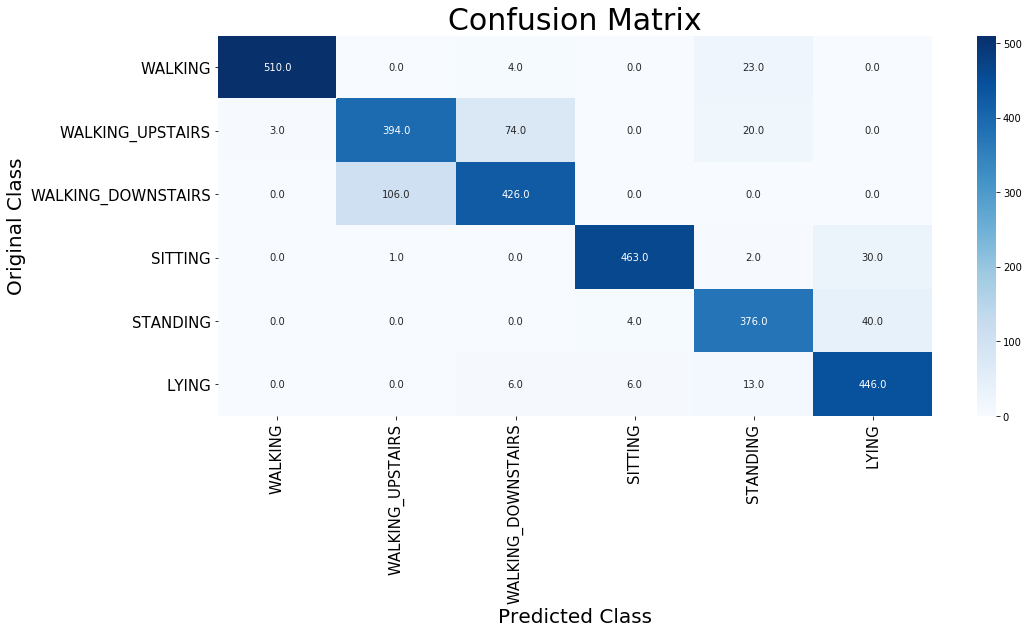


*******************Train Score********************
 

Train loss :  [1.1640531767698834, 0.775613136013911, 0.6651562674779757, 0.558171850877436, 0.47945814060049297, 0.43578528192084814, 0.4279303532722077, 0.4111309844404621, 0.40330144088468045, 0.3185965495429309, 0.27094181746212004, 0.23812793515788816, 0.21668022466059347, 0.19766557167189944, 0.1989484473488317, 0.18306765660959762, 0.18151874709428492, 0.18349276477485182, 0.1613687624743409, 0.15674153916027003, 0.16610350995197876, 0.1731151203301627, 0.17487208519214045, 0.14851875444600546, 0.17218875738572212, 0.1595686540525443, 0.1497329231721508, 0.14291946525595295, 0.18472121180449658, 0.17542162307530998]


KeyError: ignored

In [0]:
model_two_layer(32,len(X_train[0][0]),0.55,_count_classes(Y_train),'rmsprop',X_train,Y_train,16,30,X_test,Y_test)